## Bias correction

The aim is to debias the Climex2 data. ERA5-land is used as a reference here. The ibicus package is used here for bias correcting the data. The debias functions from ibicus require observations, model historical period, model future period. 

Here we are going to use the midday temperature values with the following time periods:
- Observation: ERA5-land  (1991 - 2010)
- Historical: CLIMEX (1991- 2010)
- Future: CLIMEX 20 years to select to bias correct


### User input

The user input required is:
- Future time period (20 years is required, provide start date)
- Bias correcting method
- Ensemble for Climex2 data
- Variable to debias + corresponding path 

In [68]:
import sys
import glob
import xarray as xr
import numpy as np
from dask.distributed import LocalCluster
from ibicus.debias import LinearScaling, DeltaChange, QuantileMapping, CDFt, ISIMIP, ScaledDistributionMapping
import time
import dask.array as da 
import os
import pandas as pd

In [69]:
t0 = time.time()

baseline_ens = 'hpp'
ens = 'hpp'
bias_correct = 'QM'
start_year = '1991'
end_year = '2010'
var = 'pr'


In [70]:
# Used for visualisation purposes
#client = LocalCluster().get_client()

C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63182 instead
  warnings.warn(
2025-03-28 12:08:38,280 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 16b2a0f62fd94718d4195d5c7a0e2c8b initialized by task ('rechunk-merge-rechunk-split-rechunk-transfer-0669907c1bbb912a29c511e43b94e8fd', 0, 5, 4, 0, 7, 6) executed on worker tcp://127.0.0.1:56678
2025-03-28 12:08:38,293 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ba8e583f60168a5728320d2189d6e1b8 initialized by task ('rechunk-merge-rechunk-split-rechunk-transfer-0669907c1bbb912a29c511e43b94e8fd', 0, 4, 5, 0, 6, 7) executed on worker tcp://127.0.0.1:56678
2025-03-28 12:08:38,913 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 55b00f05e0a4d8114b641a06a0d85825 initialized by task ('rechunk-merge-rechunk-transfer-a58b8ac76757e0dcd3751a94f9d67

In [71]:
#client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63182/status,
Dashboard: http://127.0.0.1:63182/status,Workers: 4
Total threads: 12,Total memory: 31.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63183,Workers: 4
Dashboard: http://127.0.0.1:63182/status,Total threads: 12
Started: Just now,Total memory: 31.65 GiB
Comm: tcp://127.0.0.1:56677,Total threads: 3
Dashboard: http://127.0.0.1:56679/status,Memory: 7.91 GiB
Nanny: tcp://127.0.0.1:63186,


### 2. Load files & preprocess data


#### Load climex data - historical (1991 - 2010)

In [34]:
years = np.arange(1991, 2011)
path = "O:/Public/sharing-4270-CERM/VLYMI/CLIMEX2/GlobusDownload/ClimExII_4_Friends/ClimExII_4_Friends/"

files = []

for year in years:
    year = str(year)
    files = files + sorted(glob.glob(path +'/'+ baseline_ens + '/' + year + '/' + var + '*.nc'))[5:10] # Select only June to October

    

In [35]:
len(files)/5 # Only considering 5months / year

20.0

In [36]:
%%time
ds_hist = xr.open_mfdataset(files)


CPU times: total: 47.7 s
Wall time: 1min 17s


In [37]:
ds_hist = ds_hist.pr.coarsen(time = 24).mean()

In [38]:
ds_hist = ds_hist.chunk(chunks={'rlat': 20, 'rlon': 20, 'time': -1})

In [39]:
len(ds_hist.time)

3060

#### Load "observations" - ERA5-land (1991 - 2010)

In [54]:
years = np.arange(1991, 2011)
path = 'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/regrided/FWI-variables/'

files =  []
for year in years:
    year = str(year)
    files = files + sorted(glob.glob(path +'prcp-' + year +'*.nc'))[5:10] # Select only June to October


len(files)/5 # Only considering 5months / year

20.0

In [55]:
%%time
ds_obs = xr.open_mfdataset(files).prcp*1000/3600/24 # mean flux in kg/m2/s

CPU times: total: 13.8 s
Wall time: 38 s


In [56]:
# Remove leap days 
ds_obs = ds_obs.sel(time = ~((ds_obs.time.dt.month == 2) & (ds_obs.time.dt.day == 29)))
ds_obs = ds_obs.chunk(chunks={'y': 20, 'x': 20, 'time': -1})

In [57]:
len(ds_obs.time)

3060

### 3. Future data to bias correct: Select 20 year period

In [72]:
years = np.arange(int(start_year), int(end_year) + 1)
path = "O:/Public/sharing-4270-CERM/VLYMI/CLIMEX2/GlobusDownload/ClimExII_4_Friends/ClimExII_4_Friends/"

files = []

for year in years:
    year = str(year)
    files = files + sorted(glob.glob(path +'/' + ens + '/' + year + '/' + var + '_' + ens + '*.nc'))[5:10] # Select only June to October

In [73]:
len(files)/5

20.0

In [74]:
%%time
ds_fut = xr.open_mfdataset(files)


CPU times: total: 43.6 s
Wall time: 58.4 s


In [75]:
# Select midday timestep
ds_fut = ds_fut.pr.coarsen(time = 24).mean()

In [76]:
ds_fut = ds_fut.chunk(chunks={'rlat': 20, 'rlon': 20, 'time': -1})

In [77]:
len(ds_fut.time)

3060

### 4. Debias data

Ibicus has an option to use dask to apply the debiaser which makes it possible to bias correct the data in Europe for a 20 year period. 

In [78]:
if bias_correct == 'QM':
    debiaser = QuantileMapping.from_variable(variable = var)
elif bias_correct == 'LS':
    debiaser = LinearScaling.from_variable(variable = var)
elif bias_correct == 'SDM':
    debiaser = ScaledDistributionMapping.from_variable(variable = var)
elif bias_correct == 'ISIMIP':
    debiaser = ISIMIP.from_variable(variable = var)
else:
    print('Not available. Options available are QM, LS, DC or SDM')
    

In [79]:
%%time 
collection = da.map_blocks(debiaser.apply, ds_obs.data, ds_hist.data, ds_fut.data, dtype=ds_obs.dtype, progressbar = False, parallel = False, failsafe = True)
debiased_cm_future = collection.compute(num_workers=8)

C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\distributed\client.py:3358: UserWarning: Sending large graph of size 12.07 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: total: 5min 33s
Wall time: 9min 12s


### 5. Save data

In [80]:
# Create folder to save data to 
save_path = 'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/CLIMEX2/debiased/' + var + '/'+ ens + '/'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [81]:
ds_fut_new = ds_fut.copy()
ds_fut_debias = ds_fut_new.to_dataset()
ds_fut_debias = ds_fut_debias.drop_vars(var)
ds_fut_debias = ds_fut_debias.assign(pr = (['time', 'rlat', 'rlon'], debiased_cm_future))
ds_fut_debias.to_netcdf(save_path + var + '_' + start_year + '-' + end_year + '_' + bias_correct +'.nc')

In [82]:
t1 = time.time()
print((t1 - t0)/60)

13.935557889938355


In [83]:
fut = ds_fut_debias.pr.values

In [84]:
hist = ds_hist.values

C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\distributed\client.py:3358: UserWarning: Sending large graph of size 11.92 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [85]:
hist[np.isnan(fut)] = np.nan

In [86]:
obs = ds_obs.values

In [87]:
np.shape(hist)

(3060, 412, 460)

In [88]:
np.nanmax(debiased_cm_future)

0.0026581779

C:\Users\ophme\AppData\Local\Temp\ipykernel_15700\2778289114.py:3: RuntimeWarning: Mean of empty slice
  a = ax.pcolor(np.nanmean(hist, axis = 0) - np.nanmean(obs, axis = 0), vmin = -0.00005, vmax = 0.00005, cmap = 'bwr' )
C:\Users\ophme\AppData\Local\Temp\ipykernel_15700\2778289114.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(a)


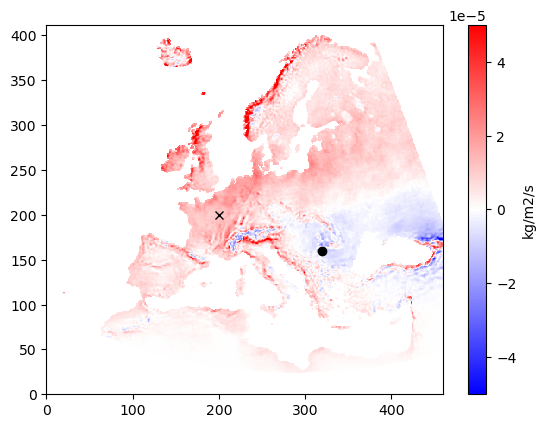

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
a = ax.pcolor(np.nanmean(hist, axis = 0) - np.nanmean(obs, axis = 0), vmin = -0.00005, vmax = 0.00005, cmap = 'bwr' )
ax.plot(200, 200, 'kx')
ax.plot(320, 160, 'ko')
cbar = fig.colorbar(a)
cbar.set_label('kg/m2/s')


Text(0.5, 1.0, 'location o')

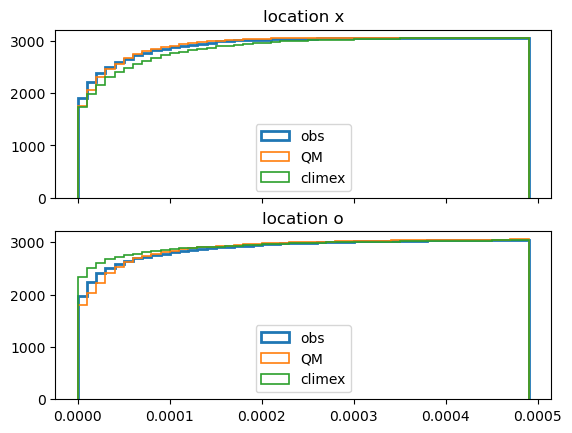

In [90]:
bins =np.arange(0, 0.0005, 0.00001)
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].hist(obs[:, 200, 200], bins = np.arange(0, 0.0005, 0.00001), histtype='step', label = 'obs', lw = 2, cumulative=True)
ax[0].hist(fut[:, 200, 200], bins = np.arange(0, 0.0005, 0.00001), histtype='step', label = 'QM', lw = 1.2, cumulative=True)
ax[0].hist(hist[:, 200, 200], bins = np.arange(0, 0.0005, 0.00001), histtype='step', label = 'climex', lw = 1.2, cumulative=True)
ax[0].legend()
ax[0].set_title('location x')

ax[1].hist(obs[:, 160, 320], bins =np.arange(0, 0.0005, 0.00001), histtype='step', label = 'obs', lw = 2, cumulative=True)
ax[1].hist(fut[:, 160, 320], bins = np.arange(0, 0.0005, 0.00001), histtype='step', label = 'QM', lw = 1.2, cumulative=True)
ax[1].hist(hist[:, 160, 320], bins = np.arange(0, 0.0005, 0.00001), histtype='step', label = 'climex', lw = 1.2, cumulative=True)
ax[1].legend()
ax[1].set_title('location o')


In [91]:
bins

array([0.0e+00, 1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05,
       7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04,
       1.4e-04, 1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04,
       2.1e-04, 2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04,
       2.8e-04, 2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3.3e-04, 3.4e-04,
       3.5e-04, 3.6e-04, 3.7e-04, 3.8e-04, 3.9e-04, 4.0e-04, 4.1e-04,
       4.2e-04, 4.3e-04, 4.4e-04, 4.5e-04, 4.6e-04, 4.7e-04, 4.8e-04,
       4.9e-04])

(0.0, 0.0002)

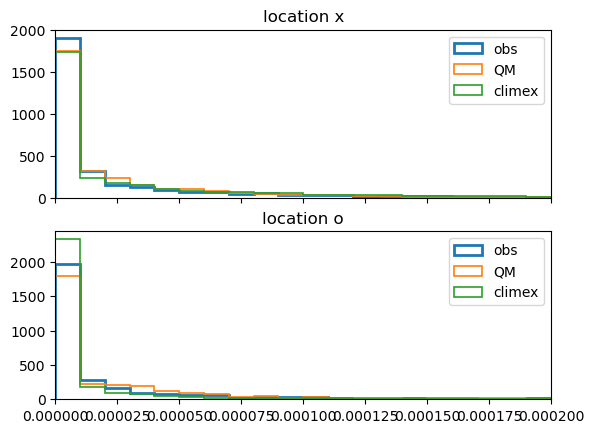

In [92]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].hist(obs[:, 200, 200], bins = bins, histtype='step', label = 'obs', lw = 2)
ax[0].hist(fut[:, 200, 200], bins = bins, histtype='step', label = 'QM', lw = 1.2)
ax[0].hist(hist[:, 200, 200], bins = bins, histtype='step', label = 'climex', lw = 1.2)
ax[0].legend()
ax[0].set_title('location x')

ax[1].hist(obs[:, 160, 320], bins = bins, histtype='step', label = 'obs', lw = 2)
ax[1].hist(fut[:, 160, 320], bins = bins, histtype='step', label = 'QM', lw = 1.2)
ax[1].hist(hist[:, 160, 320], bins = bins, histtype='step', label = 'climex', lw = 1.2)
ax[1].legend()
ax[1].set_title('location o')
ax[1].set_xlim(0, 0.0002)

(0.0, 154.0)

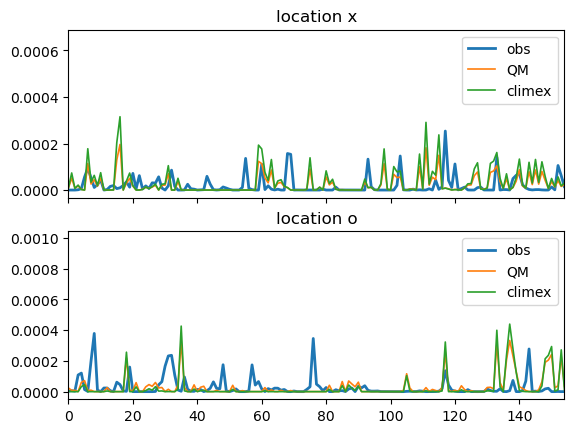

In [93]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(obs[:, 200, 200], label = 'obs', lw = 2)
ax[0].plot(fut[:, 200, 200], label = 'QM', lw = 1.2)
ax[0].plot(hist[:, 200, 200], label = 'climex', lw = 1.2)
ax[0].legend()
ax[0].set_title('location x')

ax[1].plot(obs[:, 160, 320], label = 'obs', lw = 2)
ax[1].plot(fut[:, 160, 320], label = 'QM', lw = 1.2)
ax[1].plot(hist[:, 160, 320], label = 'climex', lw = 1.2)
ax[1].legend()
ax[1].set_title('location o')
ax[0].set_xlim(0, 154)

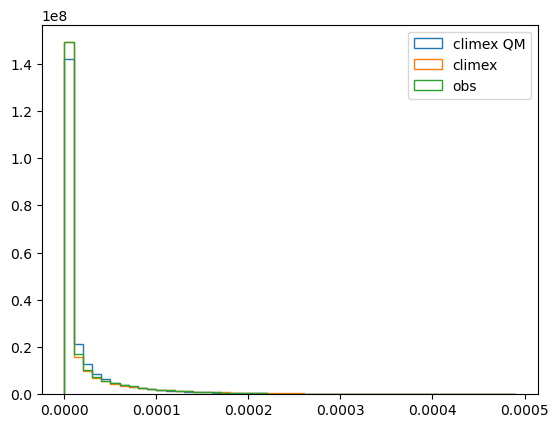

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(debiased_cm_future.flatten(), bins = bins, histtype='step', label = 'climex QM')
ax.hist(hist.flatten(), bins = bins, histtype='step', label = 'climex')
ax.hist(obs.flatten(), bins = bins, histtype='step', label = 'obs')
ax.legend()

In [ ]:
exit()